# Chapter 13 - Introduction to Nonlinear Regression and Neural Networks

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.regressionplots as smplot
from statsmodels.stats.api import het_breuschpagan, anova_lm, durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.formula.api import ols, wls, rlm, glsar
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats
import itertools as iter
from scipy.sparse.linalg import lsmr
from numpy.linalg import inv
from scipy.optimize import curve_fit

DATA_DIR = "../alsm/data"
yhat = '\u0177'
square = '\u00b2'

# 13.1 Linear and Nonlinear Regression Models (p 510)

##### Linear Regression Models

Linear models such as the general linear model (6.7)

$\quad Y_i = \beta_0 + \beta_1 X_{i1} + \beta_2 X_{i2} + \dots + \beta_{p-1} X_{i,p-1} + \epsilon_i$

are considered *linear in the parameters*. Even in the case of polynomial terms or a model like

$\quad log_{10} Y_i = \beta_0 + \beta_1 \sqrt{X_{i1}} + \beta_2 exp(X_{i2}) + \epsilon_i$

In general, we can state a linear regression model in the form

$\quad Y_i = f(X_i, \beta) + \epsilon_i$

where $X_i$ is the vector of the observations on the predictor variables for the ith case:

$\quad X_i = \begin{bmatrix} 1 \\ X_{i1} \\ \vdots \\ X_{i,p-1} \end{bmatrix}$

$\beta$ is the vector of the regression coefficients in (6.18c), and $f(X_i, \beta)$ represents the expected value $E\{Y_i\}$, which for linear regression models equals according to (6.54):

$\quad f(X_i, \beta) = X^{'}_i \beta$


##### Nonlinear Regression Models

Nonlinear regression models are of the same basic form as that for linear regression model

$\quad Y_i = f(X_i, \gamma) + \epsilon_i$

An observation $Y_i$ is still the sum of a mean response $f(X_i, \gamma)$ given by the nonlinear response function $f(X, \gamma)$ and the error term $\epsilon_i$. The error terms usually are assumed to have expectation zero, constant variance, and to be uncorrelated, just as for linear regression models. Often, a normal error model is utilized which assumes that the error terms are independent normal random variables with constant variance.

The parameter vector in the response function $f(X, \gamma)$ is now denoted by $\gamma$ rather than $\beta$ as a reminder that the response function here is *nonlinear in the parameters*. Below are two examples of nonlinear regression models that are widely used in practice.

**Exponential Regression Models**. One widely used nonlinear regression model is the exponential regression model. When there is only a single predictor variable, one form of this regression model with normal error terms is:

$\quad Y_i = \gamma_0 exp(\gamma_1 X_i) + \epsilon_i \quad\quad\quad (13.6)$

where

*  $\gamma_0$ and $\gamma_1$ are parameters
*  $X_i$ are known constants
*  $\epsilon_i$ are independent $N(0, \sigma^2)$

The response function for this model is:

$\quad f(X, \gamma)=\gamma_0 exp(\gamma_1 X)$

Note that this model is *not* linear in the parameters $\gamma_0$ and $\gamma_1$.

A more general nonlinear exponential regression model in one predictor variable with normal error term is 

$\quad Y_i = \gamma_0  + \gamma_1exp(\gamma_2 X_i) + \epsilon_i \quad\quad\quad (13.8)$

where the error terms are independent normal with constant variance $\sigma^2$. 

Exponential regression model (13.8) is commonly used in growth studies where the rate of growth at a given time $X$ is proportional to the amount of growth remaining as time increases, with $\gamma_0$ representing the maximum growth value. Another use of this regression model is to relate the concentration of a substance ($Y$) to elapsed time ($X$). Figure 13.1a shows the response function for parameter values $\gamma_0=100$, $\gamma_1=-50$, and $\gamma_2 = -2$. 

**Logistic Regression Models**. Another important nonlinear regression model is the logistic regression model. This model with one predictor variable and normal error terms is:

$\quad Y_i = \frac{\gamma_0}{1 + \gamma_1 exp(\gamma_2 X)} + \epsilon_i \quad\quad\quad (13.10)$

Note again that this response function *is not linear in the parameters* $\gamma_0$, $\gamma_1$, and $\gamma_2$.

This logistic regression model has been used in popultion studies to relate, for instance, number of species ($Y$) to time ($X$). Figure 13.1b shows the ogistic response function for parameter values $\gamma_0=10$, $\gamma_1=20$, and $\gamma_2=-2$. Note that the parameter $\gamma_0=10$ represents the maximum growth value here. 

Logistic regression model (13.10) is also widely used when the response variable is qualitative. An example fo this use of the logistic regression model is predicting whether a household will purchase a new car this year (will, will not) on the basis of the predictor variables age of presently owned car, household income, and size of household. In this use of logistic regression models, the response variable (will, will not purchase car, in our example) is qualitative and will be represented by a 0, 1 indicator variable. Consequently, the error terms are not normally distributed here with constant variance. Logistic regression models and tehir use when the response variable is qualitative will be discussed in detail in chapter 14.

**General Form of Nonlinear Regression Models**. As we have seen from the two examples of nonlinear regression models, these models are similar in general form to linear regression models. Each $Y_i$ observation is postulated to be the sum of a mean response $f(X_i, \gamma)$ based on the given onlinear response function and a random error term $\epsilon_i$. Furthermore, the error terms $\epsilon_i$ are often assumed to be independent normal rando variables with constant variance.

An important difference of nonlinear regression models is that the number of regression parameters is not necessarily directly related to the number of $X$ variables in the model. In linear regression models, if there are $p-1 X$ variables in the model, then there are $p$ regression coefficients in the model. For the exponential regression model in (13.8), there is one $X$ variable but three regression coefficients. The same is found for logistic regression model (13.10). Hence, we now denote the numberof $X$ variables in the nonlinear regression model by $q$, but we continue to denote the number of regression parameters in the response function by $p$. In the exponential regression model (13.6), for instance, there are $p=2$ regression parameters and $q=1 X$ variable.

Also, we shall define the vector $X_i$ of the observations on the $X$ variables without the initial element 1.

### Figure 13.1 (p 512)

Plots of Exponential and Logistic Response Functions

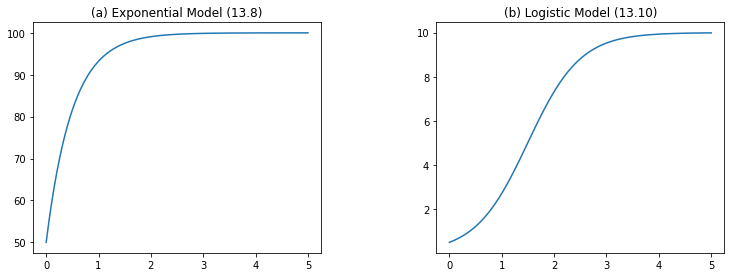

In [2]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

x = np.linspace(0, 5, 100) # 100 points between 0 and 5
y1 = 100 - 50*np.exp(-2*x)
y2 = 10 / (1 + 20*np.exp(-2*x))

ax[0].plot(x, y1)
ax[1].plot(x, y2)

ax[0].set_title("(a) Exponential Model (13.8)")
ax[1].set_title("(b) Logistic Model (13.10)")
plt.show()

### Input Severley Injured Patients Data

In [5]:
df = pd.read_pickle(f"{DATA_DIR}/CH13TA01.xz")
df.columns = ['Y', 'X']

### Table 13.1 (p 515)

Data -- Severley Injured Patients Example

In [6]:
pd.DataFrame({
    "Days Hospitalized (X)": df.X,
    "Prognostic Index (Y)": df.Y
})

,Days Hospitalized (X),Prognostic Index (Y)
0,2,54
1,5,50
2,7,45
3,10,37
4,14,35
5,19,25
6,26,20
7,31,16
8,34,18
9,38,13


### Figure 13.2 (p 515)

Scatter Plot and Fitted Nonlinear Regression Function -- Severley Injured Patients Example

###### Note

Here we make use of the scipy function `curve_fit` to take some observations `x` and determine the optimal coefficients `a` and `b` for an anonymous (lambda) function we define for the response function. The return object is a tuple with first entry fitted coefficients and second entry the covariance matrix. We directly unpack these coeffcients for use. 

fitted exponential coefficients (gamma_0, gamma_1): (58.60656622832413, 0.039586452700673055)


C:\opt\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


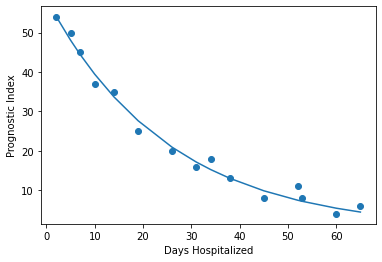

In [16]:
a, b = curve_fit(lambda x, a, b: a*np.exp(-b*x), df.X, df.Y)[0]
print(f"fitted exponential coefficients (gamma_0, gamma_1): ({a}, {b})")

y = a*np.exp(-b*df.X)
plt.scatter(df.X, df.Y)
plt.plot(df.X, y)
plt.xlabel("Days Hospitalized")
plt.ylabel("Prognostic Index")
plt.show()


# 13.2 Least Squares Estimation in Nonlinear Regression (p 515)

https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.lsmr.html#scipy.sparse.linalg.lsmr



### Table 13.2 (p 522)

$Y^{(0)}$ and $D^{(0)}$ Matrices -- Severly Injured Patients Example

In this case we can perform a linear transformation of the nonlinear functional form via 

$\quad Y^{`} = log_e(Y) = log_e(\gamma_0 exp(\gamma_1 X)) = log_e\gamma_0 + \gamma_1X = \beta_0 + \beta_1X$

While you can use this as a surrogate for the nonlinear model, it changes the error structure and can provide slightly different results, not appropriate in all cases. With other models, it might not even be possible to linearize the functional form. Instead, we use this as a basis for picking initial values for our coefficients in the Gauss-Newton method.

###### Note

As you can see in the examples, we don't need to do simple transformations of the dataframe for our ols model. Instead, you can put it into the formula using the `I(...)` expression. Then to convert the parameters back to their nonlinear forms, I simply associate (`zip`) functions to each parameter and map them together. In this case, the intercept gets passed to `np.exp` and the slope coefficient is used directly (identity function). 

In [17]:
model = ols("I(np.log(Y)) ~ X", df).fit()
display(model.summary())

g = [f(x) for f,x in zip([np.exp, lambda x: x], model.params)]  # Data-Driven Initial Guess
g

C:\opt\Anaconda3\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           I(np.log(Y))   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     276.4
Date:                Fri, 04 Jun 2021   Prob (F-statistic):           3.86e-10
Time:                        18:17:23   Log-Likelihood:                 5.5630
No. Observations:                  15   AIC:                            -7.126
Df Residuals:                      13   BIC:                            -5.710
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0372      0.084     48.002      0.000       3.855       4.219
X             -0.0380      0.002    -16.625      0.000      -0.043      -0.033
==============================================================================
Omnibus:                        1.294   Durbin-Watson:                   2.706
Prob(Omnibus):                  0.524   Jarque-Bera (JB):                0.207
Skew:                          -0.236   Prob(JB):                        0.902
Kurtosis:                       3.328   Cond. No.                         66.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

[56.66512069626944, -0.037974180811865155]

The first iteration $Y^{(0)}$ and $D^{(0)}$ combined into a single dataframe

In [18]:
D = pd.DataFrame({
    "g1": np.exp(g[1]*df.X),
    "g2": g[0]*df.X*np.exp(g[1]*df.X),
    "Y": df.Y - g[0]*np.exp(g[1]*df.X)
})
D

,g1,g2,Y
0,0.926864,105.041728,1.479136
1,0.827066,234.328945,3.134211
2,0.766578,304.067510,1.561784
3,0.684038,387.610958,-1.761096
4,0.587641,466.182722,1.701234
5,0.486018,523.265200,-2.540274
6,0.372571,548.905724,-1.111759
7,0.308140,541.285283,-1.460816
8,0.274962,529.745786,2.419242
9,0.236214,508.632705,-0.385071


The 2nd iteration $Y^{(1)}$ and $D^{(1)}$ and associated SSE

In [19]:
SSE = np.sum(D.Y**2)
fit = ols("Y ~ 0 + g1 + g2", D).fit()
g += fit.params  # Initial Guess + Least Squareds Estimated Gradient (change)
D = pd.DataFrame({
    "g1": np.exp(g[1]*df.X),
    "g2": g[0]*df.X*np.exp(g[1]*df.X),
    "Y": df.Y - g[0]*np.exp(g[1]*df.X)
})
display(D)
print(f"Change in SSE: {round(SSE - np.sum(D.Y**2), 5)}")
SSE = np.sum(D.Y**2)
SSE


,g1,g2,Y
0,0.923979,108.212729,-0.106365
1,0.820644,240.276550,1.944690
2,0.758258,310.814623,0.597911
3,0.673457,394.363246,-2.436325
4,0.574955,471.355422,1.331756
5,0.471834,524.963515,-2.629659
6,0.357772,544.710738,-0.950413
7,0.293604,532.978059,-1.192841
8,0.260768,519.181948,2.729943
9,0.222627,495.391216,-0.036611


Change in SSE: 6.61919


49.463792940644204

### Table 13.3 (p 524)

Gauss-Newton Method Iterations and Final Nonlinear Least Squares Estimates -- Severely Injured Patients Example

###### Note

Here we create helper functions to perform the calculations done manually above. 

*  `nls_step` is used for taking an initial estimate `g`, fitted the $D^{(i)}$ and $Y^{(i)}$ matrices, computing the SSE (sum of squares residual in `statsmodels`), and then computing the fitted gradient estimate using matrix algebra $(D^{T}D)^{-1}D^{T}Y$ (13.26)
*  `nls` is used for iterating through the process, either going a maximum number of times (`maxiter=100`) or until the change in SSE is less than some tolerance (`tol=1e-16`). Here we make the initial SSE infinite so that we always enter the while loop to test if the 2nd step is worth doing. Then we manually call the first iteration. We compute the likelihood ratio (ratio change in SSE). We use the estimated gradient to update the guess `g`. Then the values of the function are yielded so the result is a generator of the process.Otherwise, we go into the loop, update the step SSE with the new value and step through the process again until convergance or death.

In [ ]:
def nls_step(X, Y, g):
    g1,g2 = g
    D = np.array([
        np.exp(g2*X),
        g1*X*np.exp(g2*X)
    ]).transpose()
    Y = np.array(Y - g1*np.exp(g2*X)).reshape(-1,1)
    ssr = np.sum(Y**2)
    fit = inv(D.transpose().dot(D)).dot(D.transpose()).dot(Y)
    return fit.transpose().tolist()[0], ssr, (D, Y)

def nls(X, Y, g, tol=1e-16, maxiter=100):
    i = 0
    ssr_i = np.inf
    grad, ssr, D = nls_step(X, Y, g)
    llr = abs(ssr_i/ssr)
    g = [sum(x) for x in zip(g, grad)]
    yield i, g, ssr, llr, D
    while (llr >= tol) and (i < maxiter):
        i, ssr_i = i+1, ssr
        b, ssr, D = nls_step(X, Y, g)
        llr = abs(ssr_i-ssr)
        g = [sum(x) for x in zip(g, b)]
        yield i, g, ssr, llr, D

#### Table 13.3(a)

In [93]:
model = list(nls(df.X, df.Y, g, 1e-16))
pd.DataFrame([(g[0], g[1], sse, llr) for i, g, sse, llr, D in model], columns=["g0", "g1", "SSE", "likelihood"])

,g0,g1,SSE,likelihood
0,58.605490,-0.039585,49.463793,inf
1,58.606532,-0.039586,49.459304,4.489208e-03
2,58.606565,-0.039586,49.459300,3.866158e-06
3,58.606566,-0.039586,49.459300,4.109111e-09
4,58.606566,-0.039586,49.459300,4.384049e-12
5,58.606566,-0.039586,49.459300,7.105427e-15
6,58.606566,-0.039586,49.459300,7.105427e-15
7,58.606566,-0.039586,49.459300,3.552714e-14
8,58.606566,-0.039586,49.459300,7.105427e-15
9,58.606566,-0.039586,49.459300,0.000000e+00


#### Table 13.3(b) and 13.3(c)

Not laid out in a nice table, but all the information is there nonetheless. including the variance-covariance (`cov`) matrix, the standard errors, the MSE, and estimates. 

In [94]:
model = model[-1]
model = {
    "i": model[0],
    "params": model[1],
    "ssr": model[2],
    "llr": model[3],
    "D": model[4][0],
    "Y": model[4][1]
}
model['MSE'] = model['ssr'] / (len(model['D']) - len(model['params']))
model['cov'] = model['MSE'] * inv(model['D'].transpose().dot(model['D']))
model['bse'] = np.sqrt(model['cov'].diagonal()).tolist()
model

{'i': 9,
 'params': [58.6065663050836, -0.039586452833147996],
 'ssr': 49.45929986243336,
 'llr': 0.0,
 'D': array([[9.23880167e-01, 1.08290888e+02],
        [8.20425423e-01, 2.40411585e+02],
        [7.57974777e-01, 3.10956093e+02],
        [6.73097875e-01, 3.94479553e+02],
        [5.74525762e-01, 4.71393751e+02],
        [4.71355542e-01, 5.24866067e+02],
        [3.57275612e-01, 5.44406117e+02],
        [2.93117995e-01, 5.32537815e+02],
        [2.60295073e-01, 5.18670015e+02],
        [2.22176047e-01, 4.94797058e+02],
        [1.68403840e-01, 4.44130685e+02],
        [1.27645863e-01, 3.89006057e+02],
        [1.22691525e-01, 3.81098037e+02],
        [9.29970813e-02, 3.27014377e+02],
        [7.62971698e-02, 2.90648484e+02]]),
 'Y': array([[-0.14544424],
        [ 1.91768302],
        [ 0.57770098],
        [-2.44795527],
        [ 1.32901782],
        [-2.62452982],
        [-0.93869682],
        [-1.17863921],
        [ 2.74499956],
        [-0.02097522],
        [-1.86957079],
  

Here we see how easy it is to use the `curve_fit` function instead to get the same estimates as well as the cov matrix and associated standard errors (square root of the diagonal of cov). The SSE could be recovered by computing the residuals explicitly and thus the MSE can be recovered.

In [7]:
model = curve_fit(lambda x, a, b, c: c+a*np.exp(-b*x), df.X, df.Y)
model = {
    "params": model[0].tolist(), 
    "bse": np.sqrt(model[1].diagonal()).tolist(),
    "cov": model[1]
}
model

C:\opt\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


{'params': [57.33208647728976, 0.044603817630668445, 2.430172775652056],
 'bse': [1.828442575741837, 0.004877619457110116, 1.96550903242729],
 'cov': array([[ 3.34320225e+00, -2.16435501e-03, -1.94044956e+00],
        [-2.16435501e-03,  2.37911716e-05,  8.72015689e-03],
        [-1.94044956e+00,  8.72015689e-03,  3.86322576e+00]])}

# 13.3 Model Building and Diagnostics (p 526)

### Figure 13.3 (p 527)

Diagnostic Residual Plots -- Severely Injured Patients Example

This section is brief as these plots do not suggest any serious depatures from the model assumptions. Figure 13.3(a) does raise the question whether the error variance may be somewhat larger for cases with small fitted values near the asymptote. The Brown-Forsythe test can be conducted (not shown here). It would generate a p-value of $0.64$ indicating that the residuals are consistent with constancy of the error variance.

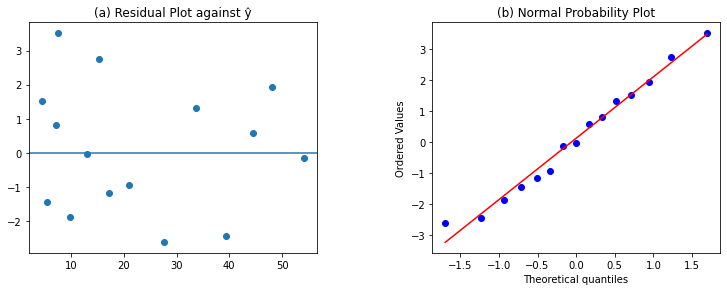

In [55]:
a,b = model['params']
fitted = a*np.exp(-b*df.X)
resid = df.Y - fitted

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

axes[0].scatter(fitted, resid)
axes[0].axhline(y=0)

qq = stats.probplot(resid, plot=axes[1])

axes[0].set_title("(a) Residual Plot against " + yhat)
axes[1].set_title("(b) Normal Probability Plot")
plt.show()


# 13.4 Inferences about Nonlinear Regression Parameters (p 527)

# 13.5 Learning Curve Example (p 533)

# 13.6 Introduction to Neural Network Modeling (p 537)